In [20]:
import pandas as pd
data = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv", sep=',')
data['Id'] = data['Id'] + '.jpg'
data = data.rename(columns={'Id': 'filename'})
data = data.drop(columns=['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'])
data

,filename,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72
...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57.jpg,15
9908,ffcc8532d76436fc79e50eb2e5238e45.jpg,70
9909,ffdf2e8673a1da6fb80342fa3b119a20.jpg,20
9910,fff19e2ce11718548fa1c5d039a5192a.jpg,20


On copie les fichiers du dataset dans une arbo de type classification

In [23]:
dataset_dir = '/kaggle/input/petfinder-pawpularity-score/train'
width, height = 512, 512
batch_size = 32

import os
path = "/kaggle/working/data"
if not os.path.exists(path):
    os.mkdir(path)

from shutil import copyfile
for i in range(50):
    mini = i * 2 + 1
    maxi = (i + 1) * 2
    class_data = data[(data['Pawpularity'] == mini) | (data['Pawpularity'] == maxi)]
    class_dir = os.path.join(path, str(mini) + '-' + str(maxi))
    os.mkdir(class_dir)
    for filename in class_data['filename']:
        src = os.path.join(dataset_dir, filename)
        dst = os.path.join(class_dir, filename)
        copyfile(src, dst)

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 9912 files belonging to 50 classes.
Using 7930 files for training.


2021-12-23 08:32:00.892653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 08:32:00.982417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 08:32:00.983086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 08:32:00.985309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 9912 files belonging to 50 classes.
Using 1982 files for validation.


In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(
    monitor="accuracy",
    min_delta=1,  # sous les 1% de mieux, on patiente
    patience=10,  # on patiente max 10 epochs
    verbose=2,
    mode="min",
    restore_best_weights=True
)
model_checkpoint_callback = ModelCheckpoint(
    'efficientNet_reg.h5',
    monitor="accuracy",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch"
)
callbacks = [early_stopping_callback, model_checkpoint_callback]

In [27]:
import sys
import os
sys.path.insert(0, "/kaggle/input/efnetv2src/efficientnet-v2-keras-main")
sys.path.append('../input/tfkeras-efficientnetsv2/')
from efficientnet_v2 import EfficientNetV2XL

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 3)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

In [38]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_addons as tfa

nb_classes = 50
efficientnet = EfficientNetV2XL(
    include_top=False,
    weights='../input/tfkeras-efficientnetsv2/21_ft1k_notop/efficientnetv2-xl-21k-ft1k_notop.h5', 
    input_shape=(height, width, 3),
    classes=nb_classes
)
efficientnet.trainable = False

inputs = Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = efficientnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
class1 = Dense(1920, activation='relu')(x)
outputs = Dense(nb_classes, activation='softmax')(class1)
efficientnet = Model(inputs, outputs)

radam = tfa.optimizers.RectifiedAdam(learning_rate=0.01)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

efficientnet.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
epochs = 100
history_efficientnet = efficientnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
248/248 [==============================] - 470s 2s/step - loss: 4.5273 - accuracy: 0.0469 - val_loss: 4.0880 - val_accuracy: 0.0494


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
248/248 [==============================] - 437s 2s/step - loss: 3.8719 - accuracy: 0.0506 - val_loss: 3.8547 - val_accuracy: 0.0545
Epoch 3/100
248/248 [==============================] - 437s 2s/step - loss: 3.6441 - accuracy: 0.0589 - val_loss: 3.7064 - val_accuracy: 0.0434
Epoch 4/100
248/248 [==============================] - 437s 2s/step - loss: 3.6101 - accuracy: 0.0580 - val_loss: 3.6149 - val_accuracy: 0.0651
Epoch 5/100
248/248 [==============================] - 437s 2s/step - loss: 3.5835 - accuracy: 0.0580 - val_loss: 3.5560 - val_accuracy: 0.0716
Epoch 6/100
248/248 [==============================] - 437s 2s/step - loss: 3.5701 - accuracy: 0.0612 - val_loss: 3.5394 - val_accuracy: 0.0535
Epoch 7/100
248/248 [==============================] - 438s 2s/step - loss: 3.5638 - accuracy: 0.0619 - val_loss: 3.5626 - val_accuracy: 0.0691
Epoch 8/100
248/248 [==============================] - 437s 2s/step - loss: 3.5601 - accuracy: 0.0629 - val_loss: 3.5502 - val_accuracy:

In [42]:
history_efficientnet.history

{'loss': [4.527331829071045,
  3.8719310760498047,
  3.6441214084625244,
  3.610069513320923,
  3.583477258682251,
  3.5701234340667725,
  3.5637621879577637,
  3.560110092163086,
  3.557889461517334,
  3.5522303581237793,
  3.5524206161499023],
 'accuracy': [0.04691046476364136,
  0.050567466765642166,
  0.058890290558338165,
  0.05800756439566612,
  0.05800756439566612,
  0.06116015091538429,
  0.0619167722761631,
  0.06292559951543808,
  0.0648171529173851,
  0.06027742847800255,
  0.06469104439020157],
 'val_loss': [4.0879807472229,
  3.8546688556671143,
  3.706392288208008,
  3.614940881729126,
  3.5560288429260254,
  3.5394012928009033,
  3.5625734329223633,
  3.550159454345703,
  3.547224760055542,
  3.5410449504852295,
  3.5545754432678223],
 'val_accuracy': [0.049445003271102905,
  0.05449041351675987,
  0.04339051619172096,
  0.065085768699646,
  0.07164480537176132,
  0.0534813329577446,
  0.06912209838628769,
  0.07164480537176132,
  0.0534813329577446,
  0.0686175599694252

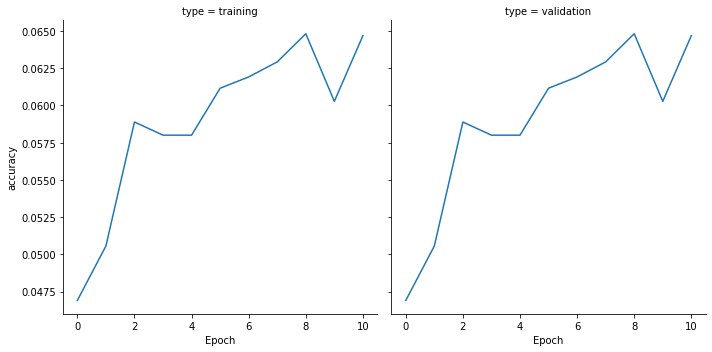

In [43]:
import matplotlib.pyplot as plt

dict1 = {
    "accuracy": history_efficientnet.history["accuracy"],
    "type": "training"
}
dict2 = {
    "accuracy": history_efficientnet.history["accuracy"],
    "type": "validation"
}
s1 = pd.DataFrame(dict1)
s2 = pd.DataFrame(dict2)
df = pd.concat([s1, s2], axis=0).reset_index()
import seaborn as sns
grid = sns.relplot(
    data=df,
    x=df["index"],
    y="accuracy",
    col="type",
    kind="line"
)
for ax in grid.axes.flat:
    ax.set(xlabel="Epoch")
plt.show()

In [29]:
import tensorflow as tf
def preprocess(image):  
    return (tf.cast(image, dtype=tf.float32) - 128.00) / 128.00

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan]]
pawpularity= 57 	prediction= nan


ValueError: cannot convert float NaN to integer

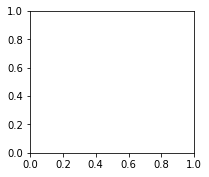

In [32]:
import numpy as np
plt.figure(figsize=(10, 12))
batch = next(test_generator)  # renvoie 32 images
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)  # 4x3 grid
    image = batch[0][i, :, :, :]  # i-ème image
    img = preprocess(image.reshape(1, width, height, 3))
    pawpularity = batch[1][i]  # i-ème pawpularity
    preds = efficientnet.predict(img)
    print(preds)
    prediction = preds.flatten()[0]
    print('pawpularity=', pawpularity, '\tprediction=', round(prediction, 2))
    diff = prediction - pawpularity
    percentDiff = (diff / pawpularity) * 100
    absPercentDiff = np.abs(percentDiff)
    plt.title("Pawpularity: " + str(pawpularity) +\
              "\npred: " + str(round(prediction, 2)) +\
              " (err=" + str(int(absPercentDiff)) + "%)")
    plt.imshow(image)
    plt.axis("off")
plt.show()
plt.close()

In [31]:
import os
from PIL import Image
test_dir = '/kaggle/input/petfinder-pawpularity-score/test'
ids = []
pawpularities = []
for test_image in os.listdir(test_dir):
    image_path = os.path.join(test_dir, test_image)
    id_image = test_image.split('.')[0]
    ids.append(id_image)
    img = Image.open(image_path) 
    img = img.resize((width, height))
    img = preprocess(np.array(img).reshape(1, width, height, 3))
    preds = efficientnet.predict(img)
    prediction = preds.flatten()[0]
    pawpularities.append(prediction)

submission_dict = {
    'Id': ids,
    'Pawpularity': pawpularities
}
submission_df = pd.DataFrame(submission_dict)
print(submission_df)
submission_df.to_csv('submission.csv', index=False, sep=',')

                                 Id  Pawpularity
0  c978013571258ed6d4637f6e8cc9d6a3          NaN
1  4e429cead1848a298432a0acad014c9d          NaN
2  43a2262d7738e3d420d453815151079e          NaN
3  8f49844c382931444e68dffbe20228f4          NaN
4  4128bae22183829d2b5fea10effdb0c3          NaN
5  80bc3ccafcc51b66303c2c263aa38486          NaN
6  e0de453c1bffc20c22b072b34b54e50f          NaN
7  b03f7041962238a7c9d6537e22f9b017          NaN
